# Li2O building PP from GBRV rho with LDA with TF02vW

In [1]:
from dftpy.ions import Ions
from dftpy.field import DirectField
from dftpy.grid import DirectGrid
from dftpy.functional import LocalPseudo, Functional, TotalFunctional
from dftpy.formats import io
from dftpy.optimization import Optimization
from dftpy.mpi import sprint
from dftpy.functional.pseudo.psp import PSP
from dftpy.constants import environ

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
# from scipy.signal import quadratic

In [3]:
from ase.build import molecule
from ase.atoms import Atoms
from ase.io import read

In [4]:
atoms = read('../../../KS/LDA/rho_ks_Li_gbrv.xsf')

In [5]:
ions, rho_ks, _ = io.read_all('../../../KS/LDA/rho_ks_Li_gbrv.xsf')
grid = rho_ks.grid


In [7]:
# import py3Dmol
# from ase.build import bulk
# from ase.io import write
# from ase.constraints import FixBondLength
# write('Li.xyz',ions)
# v = py3Dmol.view(data=open('./Li.xyz','r').read(), style='sphere',linked=False)

# v.addUnitCell()
# v.zoomTo()
# v.show()

In [8]:
PP_list = {'Li': '/projectsn/mp1009_1/Valeria/NLPP/PP/li_lda_v1.4.uspp.F.UPF',
           'O': '/projectsn/mp1009_1/Valeria/NLPP/PP/o_lda_v1.2.uspp.F.UPF'}

In [9]:
# MaxPoints=1000
# PSEUDO = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list)#, MaxPoints=MaxPoints)
rho_ini =rho_ks.copy()
PSEUDO = Functional(type='PSEUDO', grid=rho_ks.grid, ions=ions, PP_list=PP_list)
core = PSEUDO.core_density ## GBRV don't have NLCC

setting key: Li -> /projectsn/mp1009_1/Valeria/NLPP/PP/li_lda_v1.4.uspp.F.UPF
setting key: O -> /projectsn/mp1009_1/Valeria/NLPP/PP/o_lda_v1.2.uspp.F.UPF


In [10]:
KE = Functional(type='KEDF',name='TFvW', y=0.2)
XC = Functional(type='XC',name='LDA', core_density=core)
HARTREE = Functional(type='HARTREE')

In [11]:
evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)

In [12]:
optimization_options = {'econv' : 1e-11*ions.nat}
opt = Optimization(EnergyEvaluator=evaluator, optimization_options = optimization_options, optimization_method = 'CG')
rho = opt.optimize_rho(guess_rho=rho_ks)

Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       -7.322860161987E+01     -7.322860E+01   1.914656E+02    1       1       4.161842E-01    
1       -8.942832682989E+01     -1.619973E+01   2.378603E+01    1       3       1.072198E+00    
2       -9.389553957842E+01     -4.467213E+00   7.239428E+00    1       3       1.680397E+00    
3       -9.493010446901E+01     -1.034565E+00   1.011894E+01    1       2       2.079555E+00    
4       -9.528187806155E+01     -3.517736E-01   7.995441E+00    1       2       2.487719E+00    
5       -9.544617020400E+01     -1.642921E-01   3.653004E+00    1       2       2.924372E+00    
6       -9.556757311356E+01     -1.214029E-01   5.023316E+00    1       2       3.341819E+00    
7       -9.567303878984E+01     -1.054657E-01   2.394072E+00    1       2       3.932115E+00    
8       -9.573735895419E+01     -6.432016E-02   1.796158E+00    1       2       4.513397E+00    
9       -9.577976407891E+01   

In [13]:
delta = 0.5 * np.abs(rho_ks - rho).integral()

In [14]:
delta

12.121820401322356

In [15]:
kfmax=( np.max(rho) * 3 * np.pi )**(1.0/3.0)+0.2

In [16]:
from dftpy.mixer.pulay import PulayMixer

In [17]:
from dftpy.optimization import OESCF

In [18]:
pulay=PulayMixer(mp=None)

In [19]:
opt_options = {'econv' : 1e-6}

In [20]:
vW = Functional(type='KEDF', name='vW')
evaluator = TotalFunctional(KE=vW, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)

kedf_emb = Functional(type='KEDF',name='LMGP')#, kfmax=kfmax, kfmin=1e-10, ratio=1.02)
kedf_emb.options.update({'y':0})
evaluator_emb = TotalFunctional(KEDF_EMB = kedf_emb)

opt = Optimization(EnergyEvaluator=evaluator, optimization_options = opt_options, optimization_method = 'CG')
opt = OESCF(optimization=opt, evaluator_emb=evaluator_emb, guess_rho=rho,mixer=pulay)

In [26]:
rho_lmgp = opt.optimize_rho(guess_rho=rho_ks, econv=1e-6)

Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       -3.664019705027E+01     -3.664020E+01   1.622095E+02    1       1       1.246600E-01    
1       -5.402000028456E+01     -1.737980E+01   7.482019E+01    1       3       8.181579E-01    
2       -5.568257873757E+01     -1.662578E+00   1.035708E+02    1       3       1.321884E+00    
3       -5.744688568204E+01     -1.764307E+00   1.116074E+02    1       3       1.936907E+00    
4       -5.809498141253E+01     -6.480957E-01   1.012043E+02    1       3       2.707708E+00    
5       -5.888693700134E+01     -7.919556E-01   7.980972E+01    1       2       3.278171E+00    
6       -5.944922723462E+01     -5.622902E-01   4.487569E+01    1       2       3.836874E+00    
7       -5.984223423321E+01     -3.930070E-01   6.212698E+01    1       3       4.630306E+00    
8       -6.024462403547E+01     -4.023898E-01   4.478017E+01    1       3       5.396547E+00    
9       -6.051631961394E+01   

In [27]:
delta = 0.5 * np.abs(rho_ks - rho_lmgp).integral()
print(delta)

11.465192166934528


Text(0.5, 1.0, 'OF LMGP')

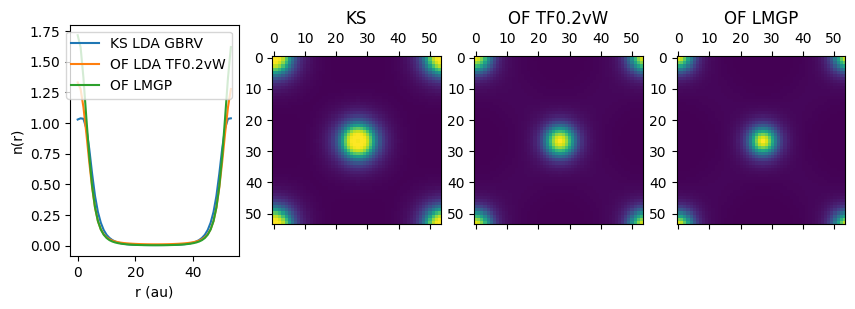

In [28]:
fig, axs = plt.subplots(1, 4, figsize=(10, 3))
r = np.linspace(0,ions.cell[2][2],len(rho_ks[0,0,:].ravel()))
cut = 0
axs[0].plot(rho_ks[:,cut,cut].ravel(), label='KS LDA GBRV')
axs[0].plot(rho[:,cut,cut].ravel(), label='OF LDA TF0.2vW')
axs[0].plot((rho_lmgp[:,cut,cut]).ravel(), label='OF LMGP')
axs[0].legend()
axs[0].set_ylabel('n(r)')
axs[0].set_xlabel('r (au)')

axs[1].matshow(rho_ks[cut,:,:])
axs[1].set_title('KS')
axs[2].matshow(rho[cut,:,:])
axs[2].set_title('OF TF0.2vW')
axs[3].matshow(rho_lmgp[cut,:,:])
axs[3].set_title('OF LMGP')

In [29]:
rho.write('rho_TF02vW_Li.xsf', ions=ions)
rho_lmgp.write('rho_LMGP_Li.xsf', ions=ions)

### PP optimitization

In [21]:
def delta_pp(r, rcut, a):
    d = r - rcut
    b = (3*a[0]*rcut-4*a[1]*rcut**2+5*a[2]*rcut**3)/2.0
    v = b*d**2 + a[0]*d**3 + a[1]*d**4+a[2]*d**5
    v[r>rcut] = 0.0
    return v

def lpp2vloc(r, v, ions, grid, key, zval=0.0):
    engine = PSP(None)
    engine.r = r
    engine.v = v
    engine._zval = zval
    pseudo = LocalPseudo(grid = grid, ions=ions, PP_list={key:engine, 'O': '/projectsn/mp1009_1/Valeria/NLPP/PP/o_lda_v1.2.uspp.F.UPF'})#, MaxPoints=MaxPoints)
    pseudo.local_PP()
    return pseudo._vreal

In [22]:
key='Li'
grid = rho_ks.grid
rcut = 2.0 # Taken from the GBRV PP cutoff radius
r = np.linspace(0, rcut, 100)
a = [ 8.94735736e+00, -3.09803611e-03, -9.10081227e-01]#np.zeros(3)
# KE = Functional(type='KEDF',name='LMGP', kfmax=kfmax, kfmin=1e-10, ratio=1.02)
KE = Functional(type='KEDF',name='TFvW', y=0.2)
evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
ext = Functional(type='EXT')
evaluator.UpdateFunctional(newFuncDict={'EXT': ext})

optimization_options = {'econv' : 1e-11*ions.nat}
opt = Optimization(EnergyEvaluator=evaluator,optimization_options = optimization_options, optimization_method = 'CG')


rho_ini = rho_ks.copy()
environ['LOGLEVEL'] = 4
def delta_rho(a):
    print('Init')
    v = delta_pp(r, rcut, a)
    ext.v = lpp2vloc(r, v, ions, grid, key)
    rho = opt.optimize_rho(guess_rho=rho_ini)
    # rho_ini[:]=rho
    diff = 0.5 * (np.abs(rho - rho_ks)).integral()
    # if i%50==0 and i>1:
    print('aa:', a, diff)
    return diff

In [23]:
res = minimize(delta_rho, a, method='Powell', options={'ftol': 1.0e-4})


Init
aa: [ 8.94735736e+00 -3.09803611e-03 -9.10081227e-01] 11.077248510816432
Init
aa: [ 8.94735736e+00 -3.09803611e-03 -9.10081227e-01] 11.077248510816432
Init
aa: [ 9.94735736e+00 -3.09803611e-03 -9.10081227e-01] 13.536603148147993
Init
aa: [ 7.32932336e+00 -3.09803611e-03 -9.10081227e-01] 17.152910160655757
Init
aa: [ 8.94735736e+00 -3.09803611e-03 -9.10081227e-01] 11.077248510816432
Init
aa: [ 8.32932339e+00 -3.09803611e-03 -9.10081227e-01] 12.816635532884135
Init
aa: [ 9.32932336e+00 -3.09803611e-03 -9.10081227e-01] 11.941511966473346
Init
aa: [ 8.91550748e+00 -3.09803611e-03 -9.10081227e-01] 11.000282284774872
Init
aa: [ 8.69160509e+00 -3.09803611e-03 -9.10081227e-01] 11.189224595131442
Init
aa: [ 8.83665341e+00 -3.09803611e-03 -9.10081227e-01] 10.86991734223436
Init
aa: [ 8.75619098e+00 -3.09803611e-03 -9.10081227e-01] 10.992056318231846
Init
aa: [ 8.83455225e+00 -3.09803611e-03 -9.10081227e-01] 10.87103765494868
Init
aa: [ 8.85681653e+00 -3.09803611e-03 -9.10081227e-01] 10.8700

In [24]:
environ['LOGLEVEL'] = 2

In [25]:
# a = res.x
key = 'Li'
r = PSEUDO.readpp.pp[key].r
zval = PSEUDO.readpp.pp[key]._zval
vl = PSEUDO.readpp.pp[key].v
v = delta_pp(r, rcut, a)
v += vl

engine = PSP(None)
engine.r = r
engine.v = v
engine.info['atomicnum'] = 3
engine._zval = zval

In [44]:
engine.write('lda_tf02vw_li2o.psp8')
np.save('a_lda_tf02vw',a)

Text(0.5, 1.0, 'Li$_2$O LPP from GBRV rho with LDA with TF02vW')

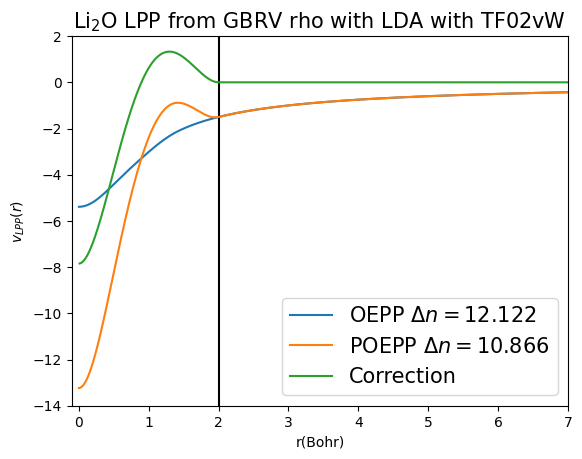

In [27]:
import matplotlib.pyplot as plt
plt.plot(r,vl, label='OEPP $\Delta n = 12.122$')
rcut = 2.0
r1=np.linspace(start=0.01,stop=10,num=1000)
# plt.plot(r,-3/(r+0.1))
#plt.scatter(np.arange(10),np.zeros(10)-4)
plt.vlines(x=rcut,ymin=-14,ymax=3,colors='k')
plt.plot(r,v, label='POEPP $\Delta n = 10.866$')
plt.plot(r1,delta_pp(r1,rcut,a), label='Correction')
plt.ylim(-14,2.0)
plt.xlim(-0.1,7)
plt.xlabel('r(Bohr)')
plt.ylabel('$v_{LPP}(r)$')
plt.legend(fontsize=15)
plt.title('Li$_2$O LPP from GBRV rho with LDA with TF02vW',fontsize=15)

In [ ]:
pwd